<a href="https://colab.research.google.com/github/Biruk-gebru/Icog-classes/blob/main/Sparcity_in_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [7]:
!pip install kaggle


In [12]:
# Install the scikit-learn library, which provides simple and efficient tools for data mining and machine learning
# This installation is specifically for Task 2
!pip install scikit-learn

# Install scikit-learn, numpy, and matplotlib libraries
# - scikit-learn: For machine learning algorithms and tools
# - numpy: For numerical computations and handling arrays
# - matplotlib: For creating static, animated, and interactive visualizations
# This installation is also for Task 2
!pip install scikit-learn numpy matplotlib

In [8]:
# Import the 'files' module from Google Colab, which provides methods for uploading and downloading files
from google.colab import files

# Invoke the upload function to open a file selection dialog box
# This enables users to upload files from their local machine to the Colab environment
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"birukgebru","key":"6dbcc18eb731d235c8b8cd2e793350d6"}'}

In [9]:
# Create a directory for Kaggle configuration files, if it doesn't already exist
!mkdir -p ~/.kaggle

# Copy the 'kaggle.json' file (which contains API credentials) to the Kaggle directory
# This file allows access to Kaggle's API for downloading datasets or submissions
!cp kaggle.json ~/.kaggle/

# Change the permissions of the 'kaggle.json' file to ensure that it is only accessible by the owner
# This is important for security
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
#download the specified dataset from kaggle
!kaggle datasets download -d puneet6060/intel-image-classification


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 98% 340M/346M [00:04<00:00, 63.2MB/s]
100% 346M/346M [00:04<00:00, 86.8MB/s]


In [11]:
#unzip the file for further use
!unzip intel-image-classification.zip -d intel-image-classification


Streaming output truncated to the last 5000 lines.
  inflating: intel-image-classification/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/

In [28]:
# Import the TensorFlow library, which provides tools for building and training machine learning models
import tensorflow as tf

# Import the image_dataset_from_directory function from Keras for loading images from a directory
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Import NumPy for numerical operations and handling arrays
import numpy as np

# Import layers and models modules from Keras for building neural network architectures
from tensorflow.keras import layers, models

# Import Matplotlib for creating visualizations of data and model performance
import matplotlib.pyplot as plt

# Import the load_img and img_to_array functions for loading and converting images to arrays
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Import DictionaryLearning from scikit-learn for dimensionality reduction and feature extraction
from sklearn.decomposition import DictionaryLearning

# Import MiniBatchDictionaryLearning from the scikit-learn library for dictionary learning with mini-batches
from sklearn.decomposition import MiniBatchDictionaryLearning

# Import OrthogonalMatchingPursuit from the scikit-learn library for performing sparse coding
from sklearn.linear_model import OrthogonalMatchingPursuit

import os

# Finalize all our imports
# The above libraries and datasets will be used for image classification tasks, model creation, data manipulation, and visualization.

In [14]:
# Load the training dataset from the specified directory
train_dataset = image_dataset_from_directory(
    'intel-image-classification/seg_train/seg_train',  # Path to the training images directory
    image_size=(150, 150),  # Resize all images to 150x150 pixels
    batch_size=32,          # Number of images to be loaded in each batch
    label_mode='int'       # Labels are provided as integers (for multi-class classification)
)

# Load the validation dataset from the specified directory
validation_dataset = image_dataset_from_directory(
    'intel-image-classification/seg_test/seg_test',  # Path to the validation images directory
    image_size=(150, 150),  # Resize all images to 150x150 pixels
    batch_size=32,          # Number of images to be loaded in each batch
    label_mode='int'       # Labels are provided as integers (for multi-class classification)
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [15]:
def manual_dropout(x, dropout_rate, training=True):
    # Check if the model is in training mode
    if training:
        # Create a random mask with the same shape as the input 'x', filled with values between 0 and 1
        # The mask is set to True (1) for values greater than the specified dropout_rate
        mask = tf.random.uniform(shape=tf.shape(x), minval=0, maxval=1) > dropout_rate

        # Apply the dropout mask to the input 'x'
        # Cast the mask to the same datatype as 'x', multiply to zero out dropped inputs
        # Rescale the remaining inputs to maintain the same expected value
        x = tf.cast(mask, dtype=x.dtype) * x / (1.0 - dropout_rate)

    # Return the modified input or the original input if not in training
    return x

In [16]:
class CustomDropout(tf.keras.layers.Layer):
    # Initialize the CustomDropout layer with a specified dropout rate
    def __init__(self, dropout_rate):
        super(CustomDropout, self).__init__()  # Call the constructor of the parent class (Layer)
        self.dropout_rate = dropout_rate  # Store the dropout rate as an instance variable

    # Define the forward computation for the CustomDropout layer
    def call(self, inputs, training=False):
        # Apply the manual dropout function to the inputs,
        # passing the dropout rate and the training flag
        return manual_dropout(inputs, self.dropout_rate, training)

In [18]:
 # Define the model using the Sequential API, which allows stacking layers linearly
model = models.Sequential([
    # Rescale pixel values from 0-255 to 0-1 for normalization, specifying the input shape
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),

    # Add a 2D convolution layer with 32 filters, kernel size of 3x3, and SELU activation function
    layers.Conv2D(32, (3, 3), activation=tf.keras.activations.selu),  # SELU instead of ReLU

    # Add a max pooling layer with a pool size of 2x2 to downsample the feature maps
    layers.MaxPooling2D((2, 2)),

    # Add another 2D convolution layer with 64 filters, kernel size of 3x3, and Swish activation function
    layers.Conv2D(64, (3, 3), activation=tf.keras.activations.swish),  # Swish

    # Add another max pooling layer to further reduce the spatial dimensions
    layers.MaxPooling2D((2, 2)),

    # Flatten the output of the previous layer to create a 1D vector
    layers.Flatten(),

    # Add a fully connected (dense) layer with 512 units and ELU activation function
    layers.Dense(512, activation=tf.keras.activations.elu),  # ELU for dense layer

    # Add the customedropout implemneted above
    CustomDropout(0.5),  # Custom Dropout

    # Add another dense layer with 6 units for the output, using softmax activation for multi-class classification
    layers.Dense(6, activation='softmax')  # Output layer for classification with 6 classes
])

In [19]:
#complie the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
#train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1076s 2s/step - accuracy: 0.4926 - loss: 3.0981 - val_accuracy: 0.7193 - val_loss: 0.8197
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1045s 2s/step - accuracy: 0.6880 - loss: 0.8589 - val_accuracy: 0.7403 - val_loss: 0.7341
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1083s 2s/step - accuracy: 0.8016 - loss: 0.5708 - val_accuracy: 0.7420 - val_loss: 0.7963
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1059s 2s/step - accuracy: 0.8617 - loss: 0.3919 - val_accuracy: 0.7493 - val_loss: 0.8170
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1100s 2s/step - accuracy: 0.9154 - loss: 0.2498 - val_accuracy: 0.7150 - val_loss: 1.1370
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1036s 2s/step - accuracy: 0.9360 - loss: 0.1859 - val_accuracy: 0.7367 - val_loss: 1.1772
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 997s 2s/step - accuracy: 0.9303 - loss: 0.2078 - val_accuracy: 0.7437 - val_loss: 1.3389
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1068s 2s/step - accuracy: 0.9425 - loss: 0.1684 - v

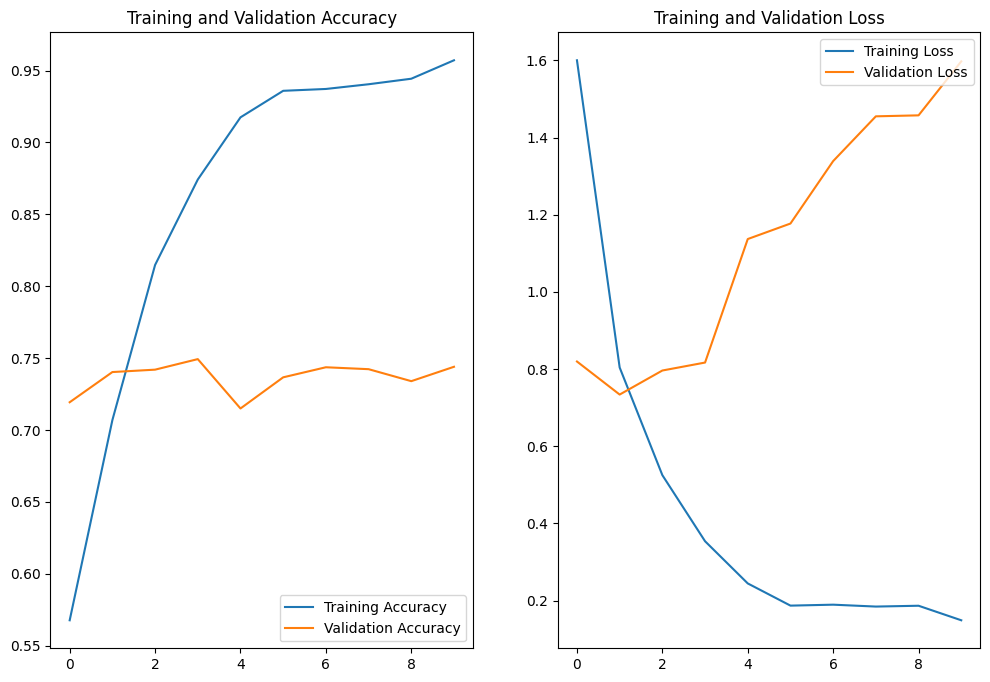

In [21]:
# Extract the training and validation metrics from the history object
acc = history.history['accuracy']           # Training accuracy values
val_acc = history.history['val_accuracy']   # Validation accuracy values
loss = history.history['loss']               # Training loss values
val_loss = history.history['val_loss']       # Validation loss values

# Define the range for the epochs (assumed 10 epochs in this case)
epochs_range = range(10)

# Create a new figure for the plots with a specified size
plt.figure(figsize=(12, 8))

# Create the first subplot for accuracy
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(epochs_range, acc, label='Training Accuracy')           # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')     # Plot validation accuracy
plt.legend(loc='lower right')  # Display the legend at the lower right corner
plt.title('Training and Validation Accuracy')  # Set the title of the subplot

# Create the second subplot for loss
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.plot(epochs_range, loss, label='Training Loss')             # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')       # Plot validation loss
plt.legend(loc='upper right')  # Display the legend at the upper right corner
plt.title('Training and Validation Loss')  # Set the title of the subplot

# Show the plot with all its elements
plt.show()

In [23]:
# Load a small subset of images from the dataset for Dictionary Learning
image_folder = 'intel-image-classification/seg_train/seg_train/buildings'  # Change category as needed
image_files = os.listdir(image_folder)[:100]  # Load only 100 images to keep it efficient

image_data = []

for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = load_img(img_path, target_size=(64, 64), color_mode="grayscale")  # Convert to grayscale
    img_array = img_to_array(img).flatten()  # Flatten into a 1D vector
    image_data.append(img_array)

image_data = np.array(image_data)
print("Image Data Shape:", image_data.shape)  # Should be (100, 4096) for 100 images of size 64x64


Image Data Shape: (100, 4096)


In [26]:
# Apply Dictionary Learning
n_components = 100  # Number of dictionary atoms
dict_learner = MiniBatchDictionaryLearning(n_components=n_components, alpha=1)
dictionary = dict_learner.fit(image_data).components_

print("Dictionary Shape:", dictionary.shape)  # Should be (100, 4096)


Dictionary Shape: (100, 4096)


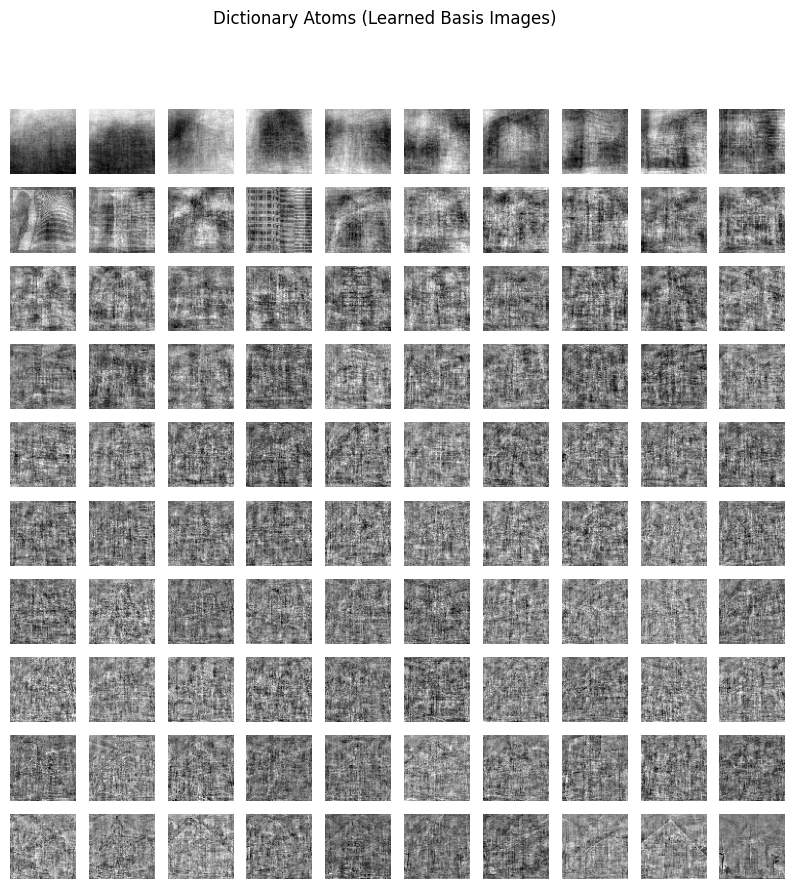

In [27]:
# Create a 10x10 grid of subplots with a specified figure size of 10x10 inches
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

# Iterate over the flattened array of axes and the corresponding indices
for i, ax in enumerate(axes.flat):
    # Reshape each dictionary atom to its original size (64x64 pixels)
    atom = dictionary[i].reshape(64, 64)

    # Display the atom as a grayscale image
    ax.imshow(atom, cmap='gray')

    # Turn off the axis for a cleaner look
    ax.axis('off')

# Set the overall title for the figure
plt.suptitle("Dictionary Atoms (Learned Basis Images)")

# Show the plotted figure with all subplots
plt.show()

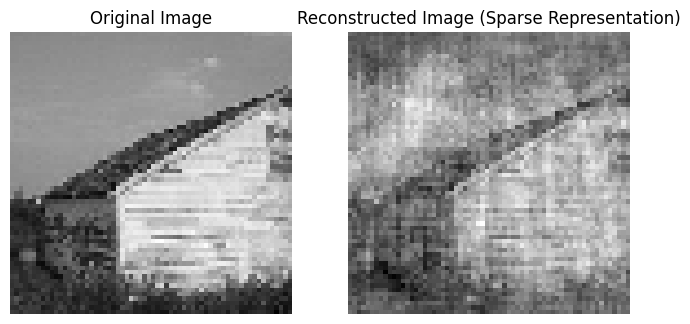

In [29]:
# Take a test image
test_img = image_data[0]  # Use the first image

# Initialize Orthogonal Matching Pursuit for sparse coding with at most 10 nonzero coefficients
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)

# Fit the OMP model to the dictionary and the test image to obtain sparse coefficients
sparse_code = omp.fit(dictionary.T, test_img).coef_

# Reconstruct the image using sparse coefficients
reconstructed_img = np.dot(sparse_code, dictionary).reshape(64, 64)

# Plot original vs reconstructed image
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(test_img.reshape(64, 64), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(reconstructed_img, cmap='gray')
axes[1].set_title("Reconstructed Image (Sparse Representation)")
axes[1].axis('off')

plt.show()